## Install the package dependencies before running this notebook

In [382]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm


"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [2]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)

## Create a DataLoader class for training

In [3]:
batch_sz = 4  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz)

## Data Visualization

### Heatmap of car routes

Heatmap of car routes in austin


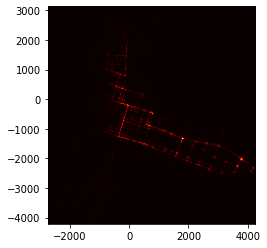

Heatmap of car routes in miami


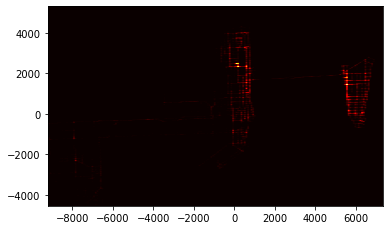

Heatmap of car routes in pittsburgh


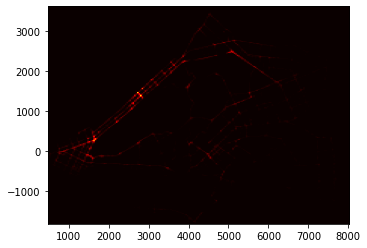

Heatmap of car routes in dearborn


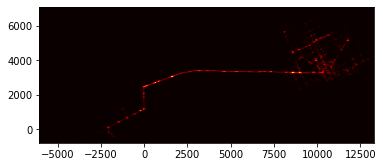

Heatmap of car routes in washington-dc


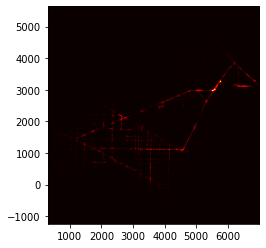

Heatmap of car routes in palo-alto


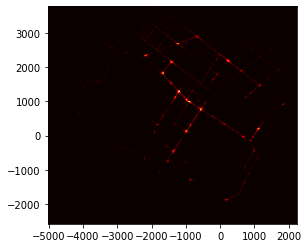

In [4]:
for n in cities:
    x = []
    y = []

    inp, out = get_city_trajectories(city=n)
    for i in inp:
        x += list(i.T[0])
        y += list(i.T[1])
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=200)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    print('Heatmap of car routes in %s' %(n))
    plt.clf()
    plt.imshow(heatmap.T, extent=extent, origin='lower', cmap = 'hot')
    plt.show()
        


## Sample a batch of data and visualize 

In [18]:
def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])
    for i_batch, sample_batch in enumerate(train_loader):
        show_sample_batch(sample_batch)
        break

## FC Model

In [602]:
input_size = 2
output_size = 2
batch_size = 4
n_layers = 2
input_seq_len = 50
output_seq_len = 60
epochs = 11

In [619]:
class FC(nn.Module):
    def __init__(self, input_size, output_size, n_layers=1):
        super(FC, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.fc1 = nn.Linear(input_size, 500)
        self.fc2 = nn.Linear(500, 1000)
        self.fc3 = nn.Linear(1000, 500)
        self.fc4 = nn.Linear(500, output_size)
        
    def forward(self, inputs):
        fc1 = self.fc1(inputs)
        fc2 = self.fc2(fc1)
        print(fc2.shape)
        fc3 = self.fc3(fc2)
        print(fc3.shape)
        output = self.fc4(fc3)
        print(output.shape)
        return output

In [620]:
fc = FC(input_size, output_size).to(device)

optimizer = optim.Adam(fc.parameters(), lr = 0.001)

lossFunction = nn.MSELoss().to(device)

In [621]:
losses = []

for n in range(epochs):

    for i_batch, sample_batch in tqdm(enumerate(train_loader)):
        inp, out = sample_batch
        inp, out = inp.to(device).to(torch.float32), out.to(device).to(torch.float32)

        fc.zero_grad()
        loss.zero_grad()

        outputs = fc(inp)
        loss = lossFunction(outputs, out)
        losses.append(loss)
        loss.backward()
        optimizer.step()


0it [00:00, ?it/s]/opt/conda/lib/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([4, 60, 2])) that is different to the input size (torch.Size([4, 50, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
0it [00:00, ?it/s]

torch.Size([4, 50, 1000])
torch.Size([4, 50, 500])
torch.Size([4, 50, 2])


RuntimeError: The size of tensor a (50) must match the size of tensor b (60) at non-singleton dimension 1

## LSTM to FC Layer Model

In [345]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [396]:
# Parameter initialization

input_size = 2
hidden_size = 128
output_size = 120
batch_size = 4
n_layers = 2
input_seq_len = 50
output_seq_len = 60
epochs = 11

In [411]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, dropout=0.01, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_size, output_size)

        
    def forward(self, inputs, hidden):
        batch_size = inputs.shape[0]
        
        output, hidden = self.lstm(inputs, hidden)
#         out: (N, input_seq_len, hidden_size)
        output = output[:,-1,:]
#         out: (N,hidden_size)
        
        output = self.fc1(output).to(device)
        output = output.view(-1,output_seq_len, self.input_size)
        return output, hidden

In [413]:
rnn = RNN(input_size, hidden_size, output_size, n_layers=n_layers).to(device)

adam = optim.Adam(rnn.parameters(), lr = 0.001)
sgd = optim.SGD(rnn.parameters(), lr=0.001, momentum=0.5)

lossFunction = nn.MSELoss().to(device)

In [414]:
adamLosses = []

for n in range(epochs):

    for i_batch, sample_batch in tqdm(enumerate(train_loader)):
        inp, out = sample_batch
        inp, out = inp.to(device).to(torch.float32), out.to(device).to(torch.float32)

        rnn.zero_grad()
        adam.zero_grad()

        outputs, hidden = rnn(inp, None)
        loss = lossFunction(outputs, out)
        adamLosses.append(loss)
        loss.backward()
        adam.step()


    


2999it [00:18, 165.88it/s]
2999it [00:17, 172.32it/s]
2999it [00:16, 178.18it/s]
2999it [00:16, 179.17it/s]
2999it [00:17, 172.83it/s]
2999it [00:16, 182.11it/s]
2999it [00:16, 181.15it/s]
2999it [00:18, 164.35it/s]
2999it [00:15, 192.74it/s]
2999it [00:16, 179.37it/s]
2999it [00:15, 189.47it/s]


In [415]:
out[0][0]

tensor([-1237.1080,  2682.2610], device='cuda:0')

In [416]:
outputs[0][0]

tensor([-1070.9739,  2163.0242], device='cuda:0', grad_fn=<SelectBackward>)

In [417]:
sgdLosses = []

for n in range(epochs):

    for i_batch, sample_batch in tqdm(enumerate(train_loader)):
        inp, out = sample_batch
        inp, out = inp.to(device).to(torch.float32), out.to(device).to(torch.float32)

        rnn.zero_grad()
        sgd.zero_grad()

        outputs, hidden = rnn(inp, None)
        loss = lossFunction(outputs, out)
        sgdLosses.append(loss)
        loss.backward()
        sgd.step()

2999it [00:15, 193.84it/s]
2999it [00:14, 211.64it/s]
2999it [00:17, 175.93it/s]
2999it [00:14, 209.07it/s]
2999it [00:15, 198.27it/s]
2999it [00:14, 205.08it/s]
2999it [00:13, 219.63it/s]
2999it [00:15, 193.02it/s]
2999it [00:15, 196.91it/s]
2999it [00:15, 192.74it/s]
2999it [00:14, 207.48it/s]


In [418]:
sgdLosses = [float(x) for x in sgdLosses]
adamLosses = [float(x) for x in adamLosses]

In [419]:
out[0][0]

tensor([-1237.1080,  2682.2610], device='cuda:0')

In [420]:
outputs[0][0]

tensor([-406.3129, 1668.6165], device='cuda:0', grad_fn=<SelectBackward>)

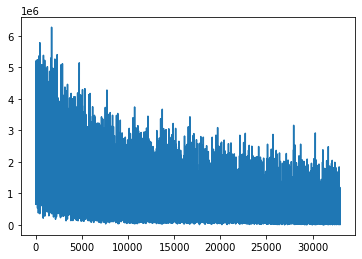

In [421]:
# Loss plot with Adam optimizer

plt.plot(range(len(adamLosses)), adamLosses)

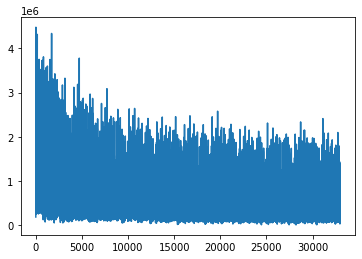

In [422]:
# Loss plot with SGD optimizer

plt.plot(range(len(sgdLosses)), sgdLosses)

In [423]:
adamLosses[-6:]

[108443.1171875,
 541887.125,
 240250.578125,
 399981.21875,
 320746.75,
 151244.859375]

In [425]:
sgdLosses[-6:]

[82762.359375, 607736.5, 504252.78125, 283305.21875, 231963.15625, 840663.5]

## 1D conv with LSTM

In [585]:
input_size = 2
hidden_size = 256
output_size = 60
batch_size = 4
n_layers = 2
seq_len = 50
epochs = 11

In [586]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.c1 = nn.Conv1d(input_size, hidden_size, 2)
        self.p1 = nn.MaxPool1d(4)
        self.c2 = nn.Conv1d(hidden_size, hidden_size, 1)
        self.p2 = nn.MaxPool1d(5)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=0.01)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, inputs, hidden):
        batch_size = inputs.shape[0]
        

        # Run through Conv1d and Pool1d layers
        c = self.c1(inputs).to(device)
        p = self.p1(c).to(device)
        c = self.c2(p).to(device)
        p = self.p2(c).to(device)
        # Turn (batch_size x hidden_size x seq_len) back into (seq_len x batch_size x hidden_size) for RNN
        p = p.transpose(1, 2).transpose(0, 1).to(device)
        
        p = F.relu(p).to(device)
        output, hidden = self.lstm(p, hidden)
        conv_seq_len = output.shape[0]
        output = output.view(conv_seq_len * batch_size, self.hidden_size).to(device) # Treating (conv_seq_len x batch_size) as batch_size for linear layer
#         output = torch.tanh(self.out(output))
        output = self.out(output).to(device)
        output = output.view( -1, self.output_size, conv_seq_len).to(device)
        return output, hidden

In [587]:
rnn = RNN(input_size, hidden_size, output_size, n_layers=n_layers).to(device)
optimizer = optim.Adam(rnn.parameters(), lr = 0.01)
lossFunction = nn.MSELoss().to(torch.float32)

In [588]:
losses = []

for n in range(epochs):

    for i_batch, sample_batch in tqdm(enumerate(train_loader)):
        inp, out = sample_batch
        inp, out = inp.to(device).to(torch.float32), out.to(device).to(torch.float32)

        rnn.zero_grad()

        outputs, hidden = rnn(inp.transpose(1,2), None)
        loss = lossFunction(outputs, out)
        losses.append(loss)
        loss.backward()
        optimizer.step()


2999it [00:15, 196.58it/s]
2999it [00:14, 213.71it/s]
2999it [00:13, 223.42it/s]
2999it [00:13, 229.41it/s]
2999it [00:13, 226.09it/s]
2999it [00:12, 232.57it/s]
2999it [00:13, 217.16it/s]
2999it [00:14, 213.70it/s]
2999it [00:12, 231.38it/s]
2999it [00:14, 211.19it/s]
2999it [00:12, 237.28it/s]


In [589]:
losses = [float(x) for x in losses]

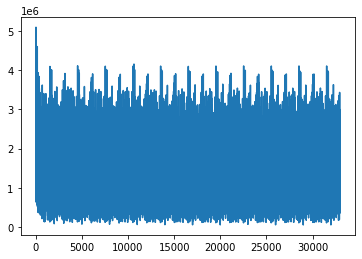

In [590]:
plt.plot(range(len(losses)), losses)

In [591]:
losses[-6:]

[653672.875, 2655459.25, 1199766.5, 754896.5625, 1152599.75, 1104365.125]